# Таблица POS_CASH_balance

`
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
`

- __SK_ID_PREV__ - ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
- __SK_ID_CURR__ - ID of loan in our sample
- __MONTHS_BALANCE__ - Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )
- __CNT_INSTALMENT__ - Term of previous credit (can change over time)
- __CNT_INSTALMENT_FUTURE__ - Installments left to pay on the previous credit
- __NAME_CONTRACT_STATUS__ - Contract status during the month
- __SK_DPD__ - DPD (days past due) during the month of previous credit
- __SK_DPD_DEF__ - DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit


In [1]:
import pandas as pd
import numpy as np
import helpers

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
POS_CASH = pd.read_csv('data/POS_CASH_balance.csv')
POS_CASH.sample(7, random_state=57)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
4168241,2562329,441437,-30,24.0,24.0,Active,0,0
9353713,1144660,110128,-81,12.0,10.0,Active,0,0
2279454,1987621,235475,-14,12.0,6.0,Active,0,0
5948861,1872805,320389,-86,8.0,7.0,Active,0,0
5587141,2122107,244736,-19,12.0,3.0,Active,0,0
595073,2642924,255377,-15,60.0,60.0,Active,0,0
4304808,1037290,215921,-6,36.0,20.0,Active,0,0


In [3]:
POS_CASH.shape

(10001358, 8)

In [3]:
helpers.get_df_general_stats(POS_CASH)

,CountNaN,RateNaN%,CountUnique,MinValue,MaxValue,Mean,Std,Median
SK_ID_PREV,0,0,936325,1000001.0,2843499.0,1.903217e+06,535846.530722,1896565.0
SK_ID_CURR,0,0,337252,100001.0,456255.0,2.784039e+05,102763.745090,278654.0
MONTHS_BALANCE,0,0,96,-96.0,-1.0,-3.501259e+01,26.066570,-28.0
CNT_INSTALMENT,26071,0,73,1.0,92.0,1.708965e+01,11.995056,12.0
CNT_INSTALMENT_FUTURE,26087,0,79,0.0,85.0,1.048384e+01,11.109058,7.0
NAME_CONTRACT_STATUS,0,0,9,NaN,NaN,NaN,NaN,NaN
SK_DPD,0,0,3400,0.0,4231.0,1.160693e+01,132.714043,0.0
SK_DPD_DEF,0,0,2307,0.0,3595.0,6.544684e-01,32.762491,0.0


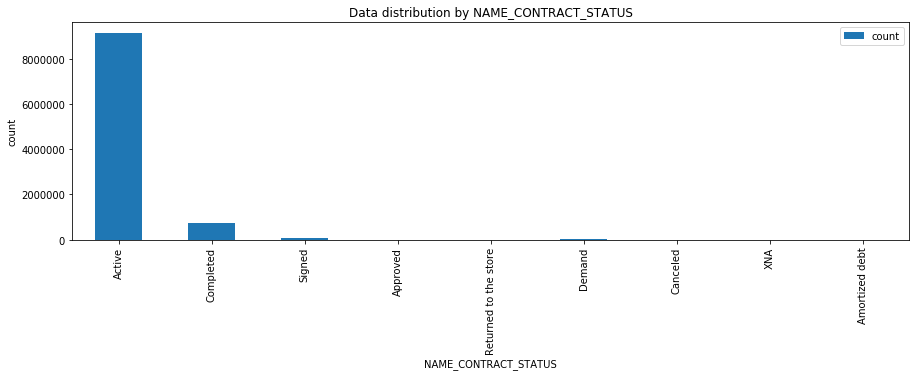

In [5]:
helpers.draw_hists_for_categorical_columns(['NAME_CONTRACT_STATUS'],POS_CASH)

In [10]:
def add_pos_cash_features(df, pos_cash):
    pos_cash_cols = []
    pos_cash_cols.append('pos_cash__previous_credits_count')
    pos_cash1 = pos_cash.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(
        columns = {'SK_ID_PREV': 'pos_cash__previous_credits_count'})
    df = df.merge(pos_cash1, on='SK_ID_CURR', how='left')
    df['pos_cash__previous_credits_count'] = df['pos_cash__previous_credits_count'].fillna(0)
    pos_cash_NUMERIC_FEATURES = [
        'SK_ID_CURR',
        'MONTHS_BALANCE',
        'CNT_INSTALMENT',
        'CNT_INSTALMENT_FUTURE',
        'SK_DPD',
        'SK_DPD_DEF',
    ]
    pos_cash_numerical_stats = pos_cash[pos_cash_NUMERIC_FEATURES].\
        groupby('SK_ID_CURR', as_index = False).\
        agg(['median', 'mean', 'max', 'min', 'sum']).reset_index()
    new_cols = []
    for feature in pos_cash_numerical_stats.columns.levels[0]:
        if feature == 'SK_ID_CURR':
            continue
        for stat in pos_cash_numerical_stats.columns.levels[1][:-1]:
            new_cols.append('pos_cash__{}_{}'.format(feature, stat))
    
    for feature in pos_cash_numerical_stats.columns:  
        ql, qr = pos_cash_numerical_stats[feature].quantile(0.01), pos_cash_numerical_stats[feature].quantile(0.99)
        pos_cash_numerical_stats.loc[pos_cash_numerical_stats[feature] > qr, feature] = qr
        pos_cash_numerical_stats.loc[pos_cash_numerical_stats[feature] < ql, feature] = ql
    pos_cash_numerical_stats.columns = ['SK_ID_CURR'] + new_cols
    df = df.merge(pos_cash_numerical_stats, on='SK_ID_CURR', how='left')
    df[new_cols] = df[new_cols].fillna(0)
    pos_cash_cols += new_cols
    return df, pos_cash_cols

In [11]:
application = pd.read_csv('data/application_train.csv')
df, _ = add_pos_cash_features(application, POS_CASH)

/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1108: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [12]:
df.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,pos_cash__previous_credits_count,pos_cash__MONTHS_BALANCE_median,pos_cash__MONTHS_BALANCE_mean,pos_cash__MONTHS_BALANCE_max,pos_cash__MONTHS_BALANCE_min,pos_cash__MONTHS_BALANCE_sum,pos_cash__CNT_INSTALMENT_median,pos_cash__CNT_INSTALMENT_mean,pos_cash__CNT_INSTALMENT_max,pos_cash__CNT_INSTALMENT_min,pos_cash__CNT_INSTALMENT_sum,pos_cash__CNT_INSTALMENT_FUTURE_median,pos_cash__CNT_INSTALMENT_FUTURE_mean,pos_cash__CNT_INSTALMENT_FUTURE_max,pos_cash__CNT_INSTALMENT_FUTURE_min,pos_cash__CNT_INSTALMENT_FUTURE_sum,pos_cash__SK_DPD_median,pos_cash__SK_DPD_mean,pos_cash__SK_DPD_max,pos_cash__SK_DPD_min,pos_cash__SK_DPD_sum,pos_cash__SK_DPD_DEF_median,pos_cash__SK_DPD_DEF_mean,pos_cash__SK_DPD_DEF_max,pos_cash__SK_DPD_DEF_min,pos_cash__SK_DPD_DEF_sum
126351,246530,0,Cash loans,F,N,Y,0,225000.0,253737.0,14697.0,229500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.025164,-15616,-934,-117.0,-4152,NaN,1,1,0,1,0,0,Medicine staff,1.0,2,2,WEDNESDAY,15,0,0,0,0,0,0,Medicine,0.733125,0.643499,0.425893,0.0928,NaN,0.9836,NaN,0.0000,0.0,0.2069,0.1667,0.0417,0.0000,0.0756,0.0881,NaN,0.0000,0.0945,NaN,0.9836,NaN,0.0000,0.0,0.2069,0.1667,0.0417,0.0000,0.0826,0.0918,NaN,0.0000,0.0937,NaN,0.9836,NaN,0.0000,0.0,0.2069,0.1667,0.0417,0.0000,0.0770,0.0897,NaN,0.0000,reg oper account,block of flats,0.0759,Panel,No,3.0,2.0,3.0,2.0,-1583.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,2.0,1.0,39.0,-18.0,-21.512821,-1.0,-52.0,-839.0,48.0,32.263158,54.0,2.0,1226.0,38.5,27.973684,54.0,0.0,1063.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
44933,152051,0,Cash loans,F,Y,N,0,135000.0,490495.5,30136.5,454500.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-13294,-1781,-2430.0,-2502,11.0,1,1,0,1,0,